<a href="https://colab.research.google.com/github/amalmajdua/Deep-Learning/blob/main/Natural_Images_Classification_using_CNN_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Note***

 ***Get data from Kaggle for 8 categories of images via the link below:***

 
 https://www.kaggle.com/datasets/prasunroy/natural-images


 ***Read the data from Google drive because it is large***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import os
import shutil

# **List Data Labels / Classes**

In [3]:
original_data_path = r'/content/drive/MyDrive/CNN/natural_images'
real_data_path = r'/content/drive/MyDrive/CNN/real'
labels = sorted(os.listdir(original_data_path))
print(labels)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [4]:
from PIL import Image

def resize_func(originl_image, size=(128,128)): 
    from PIL import Image, ImageOps 
    originl_image.thumbnail(size, Image.ANTIALIAS)
    resized_image = Image.new("RGB", size)  
    resized_image.paste(originl_image, (int((size[0] - originl_image.size[0]) / 2), int((size[1] - originl_image.size[1]) / 2)))
    return resized_image

In [5]:
new_train_path = r'NEW DATA'
size=(128,128)
for main_path, folders, files in os.walk(original_data_path):
    for sub_folder in folders:
        path_to_save = os.path.join(new_train_path,sub_folder)
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        file_names = os.listdir(os.path.join(main_path,sub_folder))
        for file_name in file_names:
            file_path = os.path.join(main_path,sub_folder, file_name)
            img = Image.open(file_path)
            resized_image = resize_func(img, size)
            to_save = os.path.join(path_to_save, file_name)
            resized_image.save(to_save)

# **Data Augmentation and Data Loade**

In [6]:
def load_dataset(data_path , real_data_path):
    aug_object = transforms.Compose([
        transforms.RandomHorizontalFlip(0.4),
        transforms.RandomVerticalFlip(0.4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    total_data = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=aug_object
    )
    
    real_data = torchvision.datasets.ImageFolder(
        root=real_data_path,
        transform=aug_object
    )
    
    
    train_precentage = int(0.9 * len(total_data))
    test_precentage = len(total_data) - train_precentage
    
    train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_precentage, test_precentage])
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=False
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=False
    )
    
    real_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=False
    )
    
        
    return train_loader, test_loader,real_loader

In [7]:
train_loader , test_loader , real_loader = load_dataset(new_train_path , real_data_path)
batch_size = train_loader.batch_size

# **Design and Build the Model Architecture**

In [8]:
class Network(nn.Module):

    def __init__(self, num_classes):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(kernel_size=2)      
        self.drop = nn.Dropout2d(p=0.3)      
        self.fc = nn.Linear(in_features=32 * 32 * 32, out_features=num_classes)

    def forward(self, x):        
        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))          
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 32 * 32 * 32)
        x = self.fc(x)
        return torch.log_softmax(x, dim=1)

model = Network(num_classes=len(labels))

print(model)

Network(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.3, inplace=False)
  (fc): Linear(in_features=32768, out_features=8, bias=True)
)


# **Define the Train Function**

In [9]:
def train_model(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    print("Epoch number is:", epoch)
    for batch_index, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        predicted_label = model(image)    
        loss = loss_function(predicted_label, label)
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()     
#         print('\tTraining batch {} Loss: {:.6f}'.format(batch_index + 1, loss.item()))
            
    average_loss = train_loss / (batch_index+1)
    print('Training set: Average loss: {:.6f}'.format(average_loss))
    return average_loss

# **Define the Test Function**

In [10]:
def test_model(model,  test_loader):
    model.eval()
    test_loss = 0
    true_cnt = 0
    with torch.no_grad():
        batch_index = 0
        for image, label in test_loader:
            batch_index += 1
            predicted_label = model(image)
            
            test_loss += loss_function(predicted_label, label).item()
            
            _, predicted = torch.max(predicted_label.data, 1)
            true_cnt += torch.sum(label==predicted).item()

    average_loss = test_loss / batch_index
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        average_loss, true_cnt, len(test_loader.dataset),100. * true_cnt / len(test_loader.dataset)))
    
    return average_loss

# **Model Training and Evaluation using Loss and Accuracy**

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_function = nn.CrossEntropyLoss()

epoch_number = []
training_loss = []
validation_loss = []

epochs = 50
for epoch in range(1, epochs + 1):
        train_loss = train_model(model, train_loader, optimizer, epoch)
        test_loss = test_model(model, test_loader)
        epoch_number.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Epoch number is: 1
Training set: Average loss: 0.663293
Validation set: Average loss: 0.366815, Accuracy: 590/693 (85%)

Epoch number is: 2
Training set: Average loss: 0.391420
Validation set: Average loss: 0.310034, Accuracy: 597/693 (86%)

Epoch number is: 3
Training set: Average loss: 0.310587
Validation set: Average loss: 0.244434, Accuracy: 618/693 (89%)

Epoch number is: 4
Training set: Average loss: 0.267829
Validation set: Average loss: 0.235135, Accuracy: 618/693 (89%)

Epoch number is: 5
Training set: Average loss: 0.243708
Validation set: Average loss: 0.238666, Accuracy: 619/693 (89%)

Epoch number is: 6
Training set: Average loss: 0.231418
Validation set: Average loss: 0.216180, Accuracy: 625/693 (90%)

Epoch number is: 7
Training set: Average loss: 0.217077
Validation set: Average loss: 0.187837, Accuracy: 630/693 (91%)

Epoch number is: 8
Training set: Average loss: 0.207808
Validation set: Average loss: 0.207765, Accuracy: 631/693 (91%)

Epoch number is: 9
Training set:

# **Training and Validation Loss Changes over Epochs**

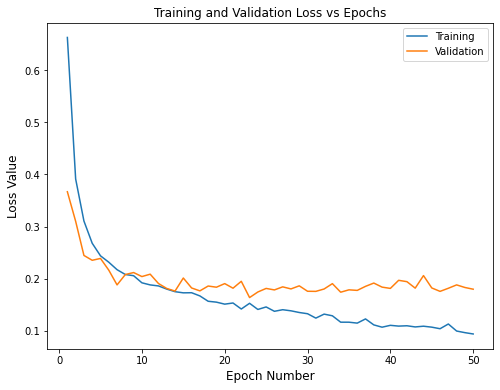

In [12]:
plt.figure(figsize=(8,6))
plt.plot(epoch_number, training_loss)
plt.plot(epoch_number, validation_loss)
plt.title('Training and Validation Loss vs Epochs', size = 12)
plt.xlabel('Epoch Number' , size = 12)
plt.ylabel('Loss Value' , size = 12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# **Confusion Matrix**

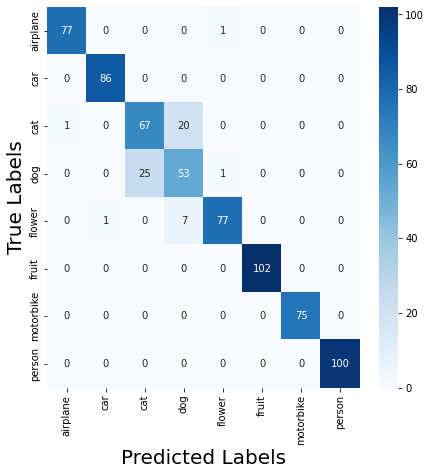

In [13]:
true_labels = []
predicted_labels = []
model.eval()
for data, target in test_loader:
    for label in target.data.numpy():
        true_labels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predicted_labels.append(prediction) 

cm = confusion_matrix(true_labels, predicted_labels)
tick_marks = np.arange(len(labels))

df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Labels", fontsize = 20)
plt.ylabel("True Labels", fontsize = 20)
plt.show()

# **Test the model on real data**

In [15]:
def test_model_real(model,  real_loader):
    test_loss = 0
    true_cnt = 0
    with torch.no_grad():
        batch_index = 0
        for image, label in real_loader:
            batch_index += 1
            predicted_label = model(image)
            
            test_loss += loss_function(predicted_label, label).item()
            
            _, predicted = torch.max(predicted_label.data, 1)
            true_cnt += torch.sum(label==predicted).item()

    average_loss = test_loss / batch_index
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        average_loss, true_cnt, len(real_loader.dataset),100. * true_cnt / len(real_loader.dataset)))
    
    return average_loss

In [16]:
real_test_loss = test_model_real(model, real_loader)

Validation set: Average loss: 0.182397, Accuracy: 641/693 (92%)

